In [1]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
from scipy.spatial import distance
import main

Generate distribution of ellipses

In [2]:
## generate distribution
grid = [100, 100]
width, height = grid
m = 2       # number of starting points
N = 128     # number of all points
r_min = 4   # minimum distance between spheres

## Selects two random points on a grid
initial = np.array([ [random.uniform(0,1)*width, random.uniform(0,1)*height] for i in range(m) ])
## and generate distribution with Mitchell algorithm
dist = main.distribution(initial, grid, N)

In [3]:
## change circles into ellipses
a, eps = 3, math.sqrt(20)/5                 # big semi-axis and eccentricity
b = a*math.sqrt(1-eps**2)       # small semi-axis
a_width, b_height = 2*a, 2*b    # small and big semi-axis for patches

new_dist = main.ellipses(dist, a, b)

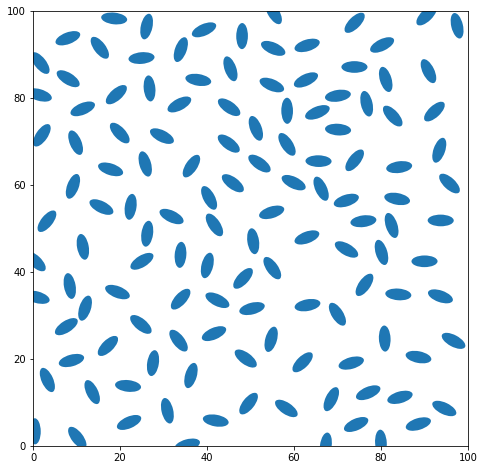

In [4]:
## generate ellipses
plt.figure(figsize=(8,8))

for center in new_dist.ell:
    ellipse = main.ellipse.convert_to_patches(center, a_width, b_height)
    plt.gca().add_patch(ellipse)

plt.axis('scaled')
plt.xlim(0.0, width)
plt.ylim(0.0, height)
# plt.savefig("elipse_512.png")
plt.show()

_____

Enlarge and rotate the ellipses

In [5]:
def change_size(a_range):
    ## change b
    b_range = a_range*math.sqrt(1-eps**2)
    a_width, b_height = 2*a_range, 2*b_range

    new_dist.a = a_range
    new_dist.b = b_range

    ## generate ellipses
    plt.figure(figsize=(6,6))

    for center in new_dist.ell:
        ellipse = main.ellipse.convert_to_patches(center, a_width, b_height)
        plt.gca().add_patch(ellipse)

    plt.axis('scaled')
    plt.xlim(0.0, width)
    plt.ylim(0.0, height)
    # plt.savefig("elipse_512.png")
    plt.show()

In [11]:
from ipywidgets import FloatSlider, interact, link

slider = FloatSlider(min=0, max=10, step=0.1, value=new_dist.a)
interact(change_size, a_range=slider)

interactive(children=(FloatSlider(value=5.0, description='a_range', max=10.0), Output()), _dom_classes=('widge…

<function __main__.change_size(a_range)>

In [12]:
## distance matrix between all the centres
S = [x.center for x in new_dist.ell]
distance_matrix = distance.cdist(S, S, dist.periodic_metric)

## matrix of indices of neighbouring ellipses, which are less than 2*a apart
in_proximity = [np.where((line<=2*new_dist.a) & (line!=0)) for line in distance_matrix]

In [17]:
## do the magic
Energy, accepted, rejected = new_dist.metropolis(in_proximity, n=10000)

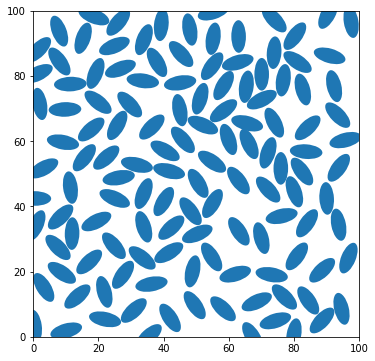

In [14]:
## generate ellipses
plt.figure(figsize=(6,6))

a_width, b_height = 2*new_dist.a, 2*new_dist.b

for center in new_dist.ell:
    ellipse = main.ellipse.convert_to_patches(center, a_width, b_height)
    plt.gca().add_patch(ellipse)

plt.axis('scaled')
plt.xlim(0.0, width)
plt.ylim(0.0, height)
# plt.savefig("elipse_512.png")
plt.show()

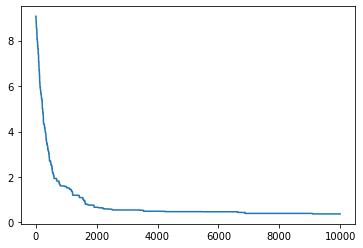

In [15]:
## check parametres
x = np.arange(len(Energy[:,0]))

## E = 1/2*u_i ---> 2x štejemo vse pare
y = 0.5*np.sum(Energy, axis=1)
plt.plot(x, y)
plt.show()

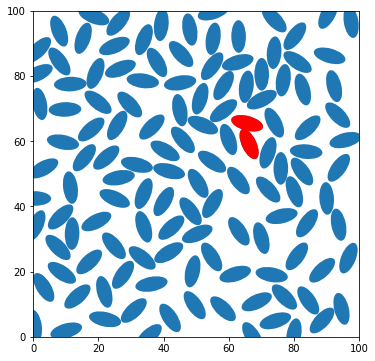

In [16]:
plt.figure(figsize=(6,6))

for center in new_dist.ell:
    ellipse = main.ellipse.convert_to_patches(center, a_width, b_height)
    plt.gca().add_patch(ellipse)

## let's draw the ones that are in contact with another colour
## first select each cluster of ellipses that has non zero energy and check which
## neighbouring ellipses overlap

non_zero = np.where(Energy[-1]!=0)[0]
in_contact = np.array([])
for j in non_zero:
    j_neighbourhood = new_dist.ell[in_proximity[j]]
    j_ellipse = new_dist.ell[j]

    close = np.array([new_dist.mu(j_ellipse, neighbour) for neighbour in j_neighbourhood])
    in_contact = np.hstack((in_contact, j_neighbourhood[np.where(close<1)]))

## het only unique entries
in_contact = set(in_contact)

## draw them in another colour for visibility
for center in in_contact:
    ell_patch = main.ellipse.convert_to_patches(center, a_width, b_height)
    plt.gca().add_patch(ell_patch)
    ell_patch.set_facecolor('r')


plt.axis('scaled')
plt.xlim(0.0, width)
plt.ylim(0.0, height)
plt.show()

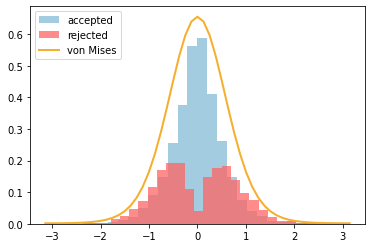

In [18]:
## histograms that have to be normalised
from scipy.special import i0


hist1, bins1 = np.histogram(accepted[~np.isnan(accepted)], bins=30)
hist2, bins2 = np.histogram(rejected[~np.isnan(rejected)], bins=30)

norm = np.sum(hist1*np.diff(bins1)) + np.sum((hist2)*np.diff(bins2))
wgt = [np.ones_like(accepted)/norm, np.ones_like(rejected)/norm]

plt.hist(accepted, bins=bins1, facecolor='#86BBD8', weights=wgt[0], alpha=0.75, label='accepted')
plt.hist(rejected, bins=bins2, facecolor='#FF6663', weights=wgt[1], alpha=0.75, label='rejected')

mu, kappa = 0, 3
x = np.linspace(-math.pi, math.pi, num=51)
y = np.exp(kappa*np.cos(x-mu))/(2*np.pi*i0(kappa))
plt.plot(x, y, linewidth=2, color='#F6AE2D', label='von Mises')
plt.legend(loc='upper left')

plt.show()